## TODO

* Show how to create jet images
* Find a clean way to load data from datasets (save to disk?). Check I don't get RAM problems on Colab

## Imports

In [14]:
from datasets import load_dataset
from fastai.vision.all import *
from torch.utils.data import TensorDataset
from torchvision import transforms

## fastai demo

In [2]:
path = untar_data(URLs.PETS)
files = get_image_files(path / "images")


def label_func(f):
    return f[0].isupper()


dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

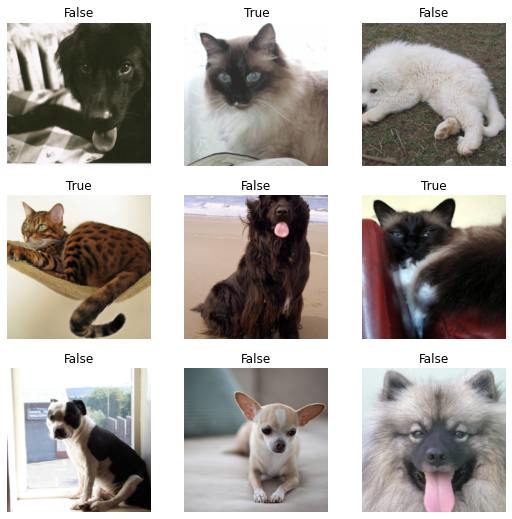

In [3]:
dls.show_batch()

In [4]:
dls.train_ds[0]

(PILImage mode=RGB size=500x335, TensorCategory(1))

In [5]:
next(iter(dls.train))[0].shape

torch.Size([64, 3, 224, 224])

In [6]:
next(iter(dls.train))[0][0]

TensorImage([[[0.7059, 0.7216, 0.7294,  ..., 0.4392, 0.4392, 0.4196],
         [0.7059, 0.7216, 0.7294,  ..., 0.4392, 0.4392, 0.4196],
         [0.7059, 0.7176, 0.7294,  ..., 0.4392, 0.4392, 0.4275],
         ...,
         [0.3333, 0.3373, 0.3176,  ..., 0.1647, 0.1608, 0.1686],
         [0.3373, 0.3451, 0.3176,  ..., 0.1725, 0.1765, 0.1804],
         [0.3216, 0.3255, 0.3059,  ..., 0.1843, 0.1765, 0.1765]],

        [[0.8510, 0.8667, 0.8745,  ..., 0.4784, 0.4784, 0.4706],
         [0.8510, 0.8667, 0.8745,  ..., 0.4784, 0.4784, 0.4706],
         [0.8510, 0.8627, 0.8745,  ..., 0.4784, 0.4784, 0.4667],
         ...,
         [0.2510, 0.2549, 0.2353,  ..., 0.0706, 0.0824, 0.0902],
         [0.2627, 0.2627, 0.2353,  ..., 0.0784, 0.0902, 0.1020],
         [0.2549, 0.2510, 0.2314,  ..., 0.1020, 0.0980, 0.0980]],

        [[0.9137, 0.9294, 0.9373,  ..., 0.5137, 0.5137, 0.5059],
         [0.9137, 0.9294, 0.9373,  ..., 0.5137, 0.5137, 0.5059],
         [0.9137, 0.9255, 0.9373,  ..., 0.5137, 0.513

In [16]:
next(iter(dls.train))[1].shape

torch.Size([64])

In [5]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

In [6]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.139874,0.029827,0.010149,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.059497,0.031142,0.008796,00:14


## Load data

In [7]:
images_ds = load_dataset("dl4phys/top_tagging_images")
images_ds

Using custom data configuration dl4phys--top_landscape_images-9b271235338645d2
Reusing dataset parquet (/home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 403000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 404000
    })
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1211000
    })
})

In [8]:
images_ds["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
 'label': 0}

In [119]:
sample_ds = images_ds["train"].shuffle(seed=42).select(range(100_000))

Loading cached shuffled indices for dataset at /home/lewis/.cache/huggingface/datasets/dl4phys___parquet/dl4phys--top_landscape_images-9b271235338645d2/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-e4ab030cda4c4b0b.arrow


In [120]:
sample_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=40x40>,
 'label': 1}

In [141]:
train_ds = images_ds["train"]

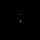

In [142]:
images = train_ds[:]["image"]
images[0]

In [122]:
transforms.ToTensor()(images[0]).shape

torch.Size([1, 40, 40])

In [143]:
labels = train_ds[:]["label"]

In [144]:
train_x = torch.cat([transforms.ToTensor()(img) for img in images]).unsqueeze(1)
train_y = torch.cat([torch.tensor(l).unsqueeze(0) for l in labels])

In [148]:
train_x.shape

torch.Size([1211000, 1, 40, 40])

In [149]:
train_ds = TensorDataset(train_x, train_y)

In [147]:
train_ds[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor(0))

In [150]:
valid_ds = images_ds["validation"]
valid_images = valid_ds[:]["image"]
valid_labels = valid_ds[:]["label"]

In [151]:
valid_x = torch.cat([transforms.ToTensor()(img) for img in valid_images]).unsqueeze(1)
valid_y = torch.cat([torch.tensor(l).unsqueeze(0) for l in valid_labels])

In [152]:
valid_ds = TensorDataset(valid_x, valid_y)

In [162]:
train_dl = DataLoader(train_ds, bs=128, shuffle=True)
valid_dl = DataLoader(valid_ds, bs=128, shuffle=True)

In [154]:
xb, yb = first(train_dl)
xb.shape

torch.Size([64, 1, 40, 40])

In [163]:
dls = DataLoaders(train_dl, valid_dl)

In [164]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks // 2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

In [165]:
simple_cnn = nn.Sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16,32),
    conv(32, 16),
    conv(16, 2, act=False),
    Flatten()
)

In [166]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [169]:
learn = Learner(dls, simple_cnn, metrics=[accuracy, RocAucBinary()], loss_func=F.cross_entropy)

In [170]:
learn.summary()

Sequential (Input shape: 128 x 1 x 40 x 40)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 4 x 20 x 20   
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 8 x 10 x 10   
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 5 x 5    
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 3 x 3    
Conv2d                                    4640       True      
ReLU                                         

SuggestedLRs(valley=0.001737800776027143)

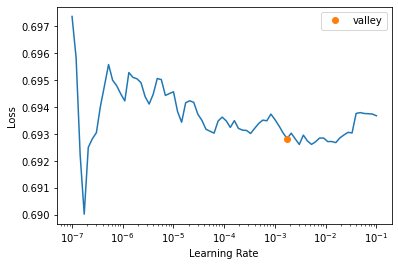

In [161]:
learn.lr_find()

In [171]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.215035,0.212752,0.911978,0.970973,00:52
1,0.246079,0.251165,0.897605,0.961618,00:52
2,0.216769,0.222152,0.906655,0.970078,00:52
3,0.207108,0.206460,0.915332,0.972643,00:52
4,0.203267,0.202196,0.917199,0.973573,00:53
